In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from plotnine import ggplot, aes, geom_bar, labs, theme, element_text, position_dodge, stat_summary, geom_errorbar, geom_boxplot, scale_fill_manual
from plotnine import ggplot, position_dodge, element_blank, geom_line, geom_abline, labs, theme, geom_area, scale_fill_gradient, geom_tile, geom_text, scale_fill_gradient2

In [ ]:
df = pd.read_excel("marketing_campaign.xlsx")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [ ]:
df.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [ ]:
# Income has 24 missing values, let's use education to calculate medians to fill in those missing values
# If education of those missing columns equals the specified education level, it will fill the missing income values with the median

df.loc[((df['Income'].isna()) & (df['Education'] == 'Basic')),'Income'] = df[df['Education'] == 'Basic']['Income'].median()
df.loc[((df['Income'].isna()) & (df['Education'] == 'Graduation')),'Income'] = df[df['Education'] == 'Graduation']['Income'].median()
df.loc[((df['Income'].isna()) & (df['Education'] == '2n Cycle')),'Income'] = df[df['Education'] == '2n Cycle']['Income'].median()
df.loc[((df['Income'].isna()) & (df['Education'] == 'Master')),'Income'] = df[df['Education'] == 'Master']['Income'].median()
df.loc[((df['Income'].isna()) & (df['Education'] == 'PhD')),'Income'] = df[df['Education'] == 'PhD']['Income'].median()



In [ ]:
df = df.rename(columns={'Education': 'education',
                         'Marital_Status': 'marital',
                         })
df = pd.get_dummies(df, drop_first = False, columns=['education', 'marital'])
df.columns

Index(['ID', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer',
       'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'education_2n Cycle', 'education_Basic', 'education_Graduation',
       'education_Master', 'education_PhD', 'marital_Absurd', 'marital_Alone',
       'marital_Divorced', 'marital_Married', 'marital_Single',
       'marital_Together', 'marital_Widow', 'marital_YOLO'],
      dtype='object')

In [ ]:
# Feature Engineering
df['MntTotal'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

df['MntRegularProds'] =  df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts']

df ['AcceptedCmpOverall'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5']


In [ ]:
df['NumPurchases'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']

In [ ]:
df['AvgMntPerPurchase'] = df['MntTotal']/df['NumPurchases']

df.loc[df['AvgMntPerPurchase']==np.inf, 'AvgMntPerPurchase'] = 0

df['AvgRegMntPerPurchase'] = df['MntRegularProds']/df['NumPurchases']
df.loc[df['AvgRegMntPerPurchase']==np.inf, 'AvgRegMntPerPurchase'] = 0

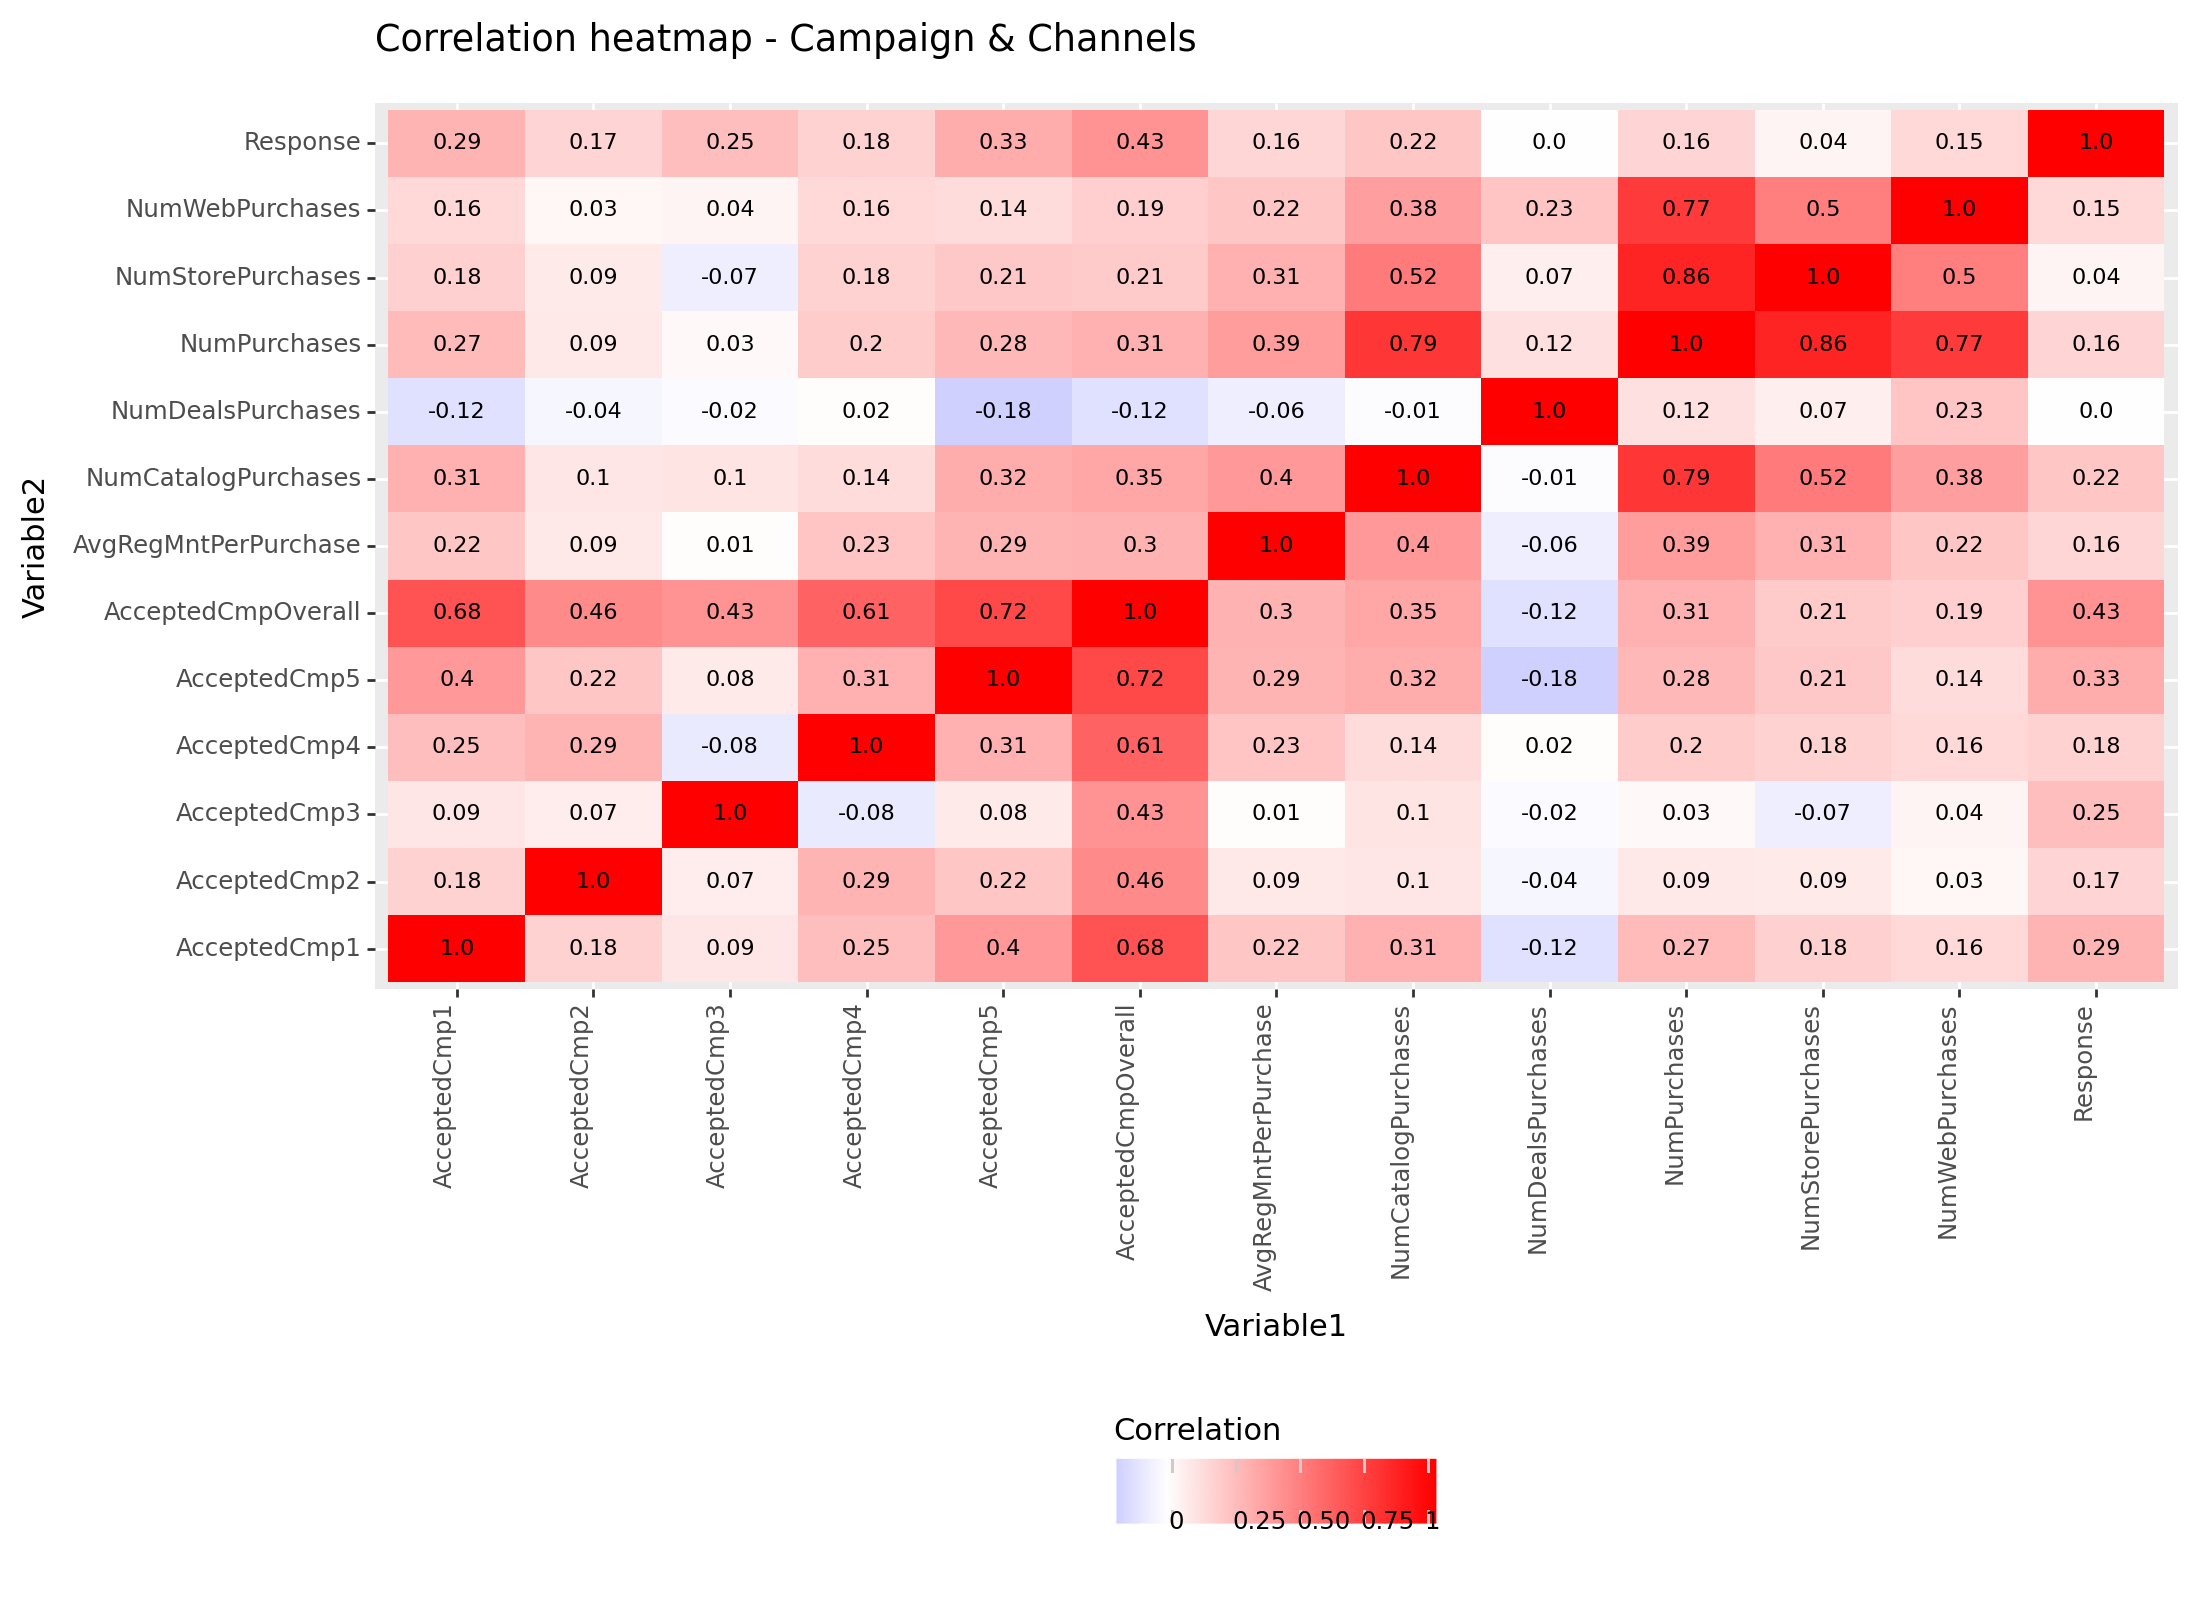

<Figure Size: (1100 x 800)>

In [ ]:
# Calculating the correlation matrix
corr_matrix = df[['Response', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4',
                  'AcceptedCmp5', 'AcceptedCmpOverall', 'NumDealsPurchases', 'NumWebPurchases',
                  'NumCatalogPurchases', 'NumStorePurchases', 'NumPurchases', 'AvgRegMntPerPurchase']].corr()

corr_df = corr_matrix.reset_index().melt(id_vars='index')
corr_df.columns = ['Variable1', 'Variable2', 'Correlation']

heatmap = (
    ggplot(corr_df, aes(x='Variable1', y='Variable2', fill='Correlation')) +
    geom_tile() +
    geom_text(aes(label='round(Correlation, 2)'), size=8) +
    scale_fill_gradient2(low='blue', mid='white', high='red', midpoint=0) +
    labs(title='Correlation heatmap - Campaign & Channels') +
    theme(
        axis_text_x=element_text(angle=90, hjust=1),
        figure_size=(11, 8),
        legend_position='bottom'
    )
)

heatmap

In [ ]:
df = df.drop(['NumPurchases', 'AvgRegMntPerPurchase'], axis=1)

In [ ]:
df_copy = df.copy()
df_copy = df_copy.reset_index()

df_copy = df_copy.drop([ 'AvgMntPerPurchase',
                    'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4',
                    'AcceptedCmp5'
                   ], axis=1)
df_copy.columns

Index(['index', 'ID', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome',
       'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'Complain', 'Z_CostContact',
       'Z_Revenue', 'Response', 'education_2n Cycle', 'education_Basic',
       'education_Graduation', 'education_Master', 'education_PhD',
       'marital_Absurd', 'marital_Alone', 'marital_Divorced',
       'marital_Married', 'marital_Single', 'marital_Together',
       'marital_Widow', 'marital_YOLO', 'MntTotal', 'MntRegularProds',
       'AcceptedCmpOverall'],
      dtype='object')

In [ ]:
predictors = ['index', 'ID', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome',
        'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'Complain', 'Z_CostContact',
       'Z_Revenue', 'education_2n Cycle', 'education_Basic',
       'education_Graduation', 'education_Master', 'education_PhD',
       'marital_Absurd', 'marital_Alone', 'marital_Divorced',
       'marital_Married', 'marital_Single', 'marital_Together',
       'marital_Widow', 'marital_YOLO', 'MntTotal', 'MntRegularProds',
       'AcceptedCmpOverall']
contin = ['index', 'ID', 'Year_Birth', 'Income', 'Kidhome','Recency','MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth','MntTotal', 'MntRegularProds',
       'AcceptedCmpOverall']

X = df_copy[predictors]
y = df_copy["Response"]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state = 123)
#random_state makes sure we have the same split each time

# Create Empty Model
pre = make_column_transformer((StandardScaler(), contin),
                              remainder = "passthrough")
lr = LogisticRegression()

pipe = Pipeline([("pre", pre), ("model", lr)])

# fit
pipe.fit(X_train, y_train)

# predict

y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

y_pred_train_prob = pipe.predict_proba(X_train)[:,1]
y_pred_test_prob = pipe.predict_proba(X_test)[:,1]

# assess
print("Train Acc       : ", accuracy_score(y_train, y_pred_train))
print("Train Prescision: ", precision_score(y_train, y_pred_train))
print("Train Recall    : ", recall_score(y_train, y_pred_train))
print("Train F1        : ", f1_score(y_train, y_pred_train))
print("Train ROC AUC   : ", roc_auc_score(y_train, y_pred_train_prob))


print("Test Acc        : ", accuracy_score(y_test, y_pred_test))
print("Test Prescision : ", precision_score(y_test, y_pred_test))
print("Test Recall     : ", recall_score(y_test, y_pred_test))
print("Test F1         : ", f1_score(y_test, y_pred_test))
print("Test ROC AUC    : ", roc_auc_score(y_test, y_pred_test_prob))

Train Acc       :  0.8878348214285714
Train Prescision:  0.7133757961783439
Train Recall    :  0.417910447761194
Train F1        :  0.5270588235294117
Train ROC AUC   :  0.8869726172288165
Test Acc        :  0.90625
Test Prescision :  0.8
Test Recall     :  0.48484848484848486
Test F1         :  0.6037735849056605
Test ROC AUC    :  0.8896557194986514


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

predictors = ['index', 'ID', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome',
        'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'Complain', 'Z_CostContact',
       'Z_Revenue', 'education_2n Cycle', 'education_Basic',
       'education_Graduation', 'education_Master', 'education_PhD',
       'marital_Absurd', 'marital_Alone', 'marital_Divorced',
       'marital_Married', 'marital_Single', 'marital_Together',
       'marital_Widow', 'marital_YOLO', 'MntTotal', 'MntRegularProds',
       'AcceptedCmpOverall']
contin = ['index', 'ID', 'Year_Birth', 'Income', 'Kidhome','Recency','MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth','MntTotal', 'MntRegularProds',
       'AcceptedCmpOverall']
X = df_copy[predictors]
y = df_copy["Response"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Create Column Transformer for scaling
pre = ColumnTransformer(transformers=[('scale', StandardScaler(), contin)], remainder='passthrough')

# Create Logistic Regression Model
lr = LogisticRegression()

# Create Pipeline with SMOTE and Logistic Regression
pipe = ImbPipeline(steps=[('pre', pre), ('smote', SMOTE(random_state=123)), ('model', lr)])

# Fit the pipeline
pipe.fit(X_train, y_train)

# Predict
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

y_pred_train_prob = pipe.predict_proba(X_train)[:, 1]
y_pred_test_prob = pipe.predict_proba(X_test)[:, 1]

# Assess
print("Train Acc       : ", accuracy_score(y_train, y_pred_train))
print("Train Precision : ", precision_score(y_train, y_pred_train))
print("Train Recall    : ", recall_score(y_train, y_pred_train))
print("Train F1        : ", f1_score(y_train, y_pred_train))
print("Train ROC AUC   : ", roc_auc_score(y_train, y_pred_train_prob))

print("Test Acc        : ", accuracy_score(y_test, y_pred_test))
print("Test Precision  : ", precision_score(y_test, y_pred_test))
print("Test Recall     : ", recall_score(y_test, y_pred_test))
print("Test F1         : ", f1_score(y_test, y_pred_test))
print("Test ROC AUC    : ", roc_auc_score(y_test, y_pred_test_prob))

Train Acc       :  0.8231026785714286
Train Precision :  0.44731182795698926
Train Recall    :  0.7761194029850746
Train F1        :  0.567530695770805
Train ROC AUC   :  0.8893818310024678
Test Acc        :  0.8370535714285714
Test Precision  :  0.46601941747572817
Test Recall     :  0.7272727272727273
Test F1         :  0.5680473372781065
Test ROC AUC    :  0.8875138822782801


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


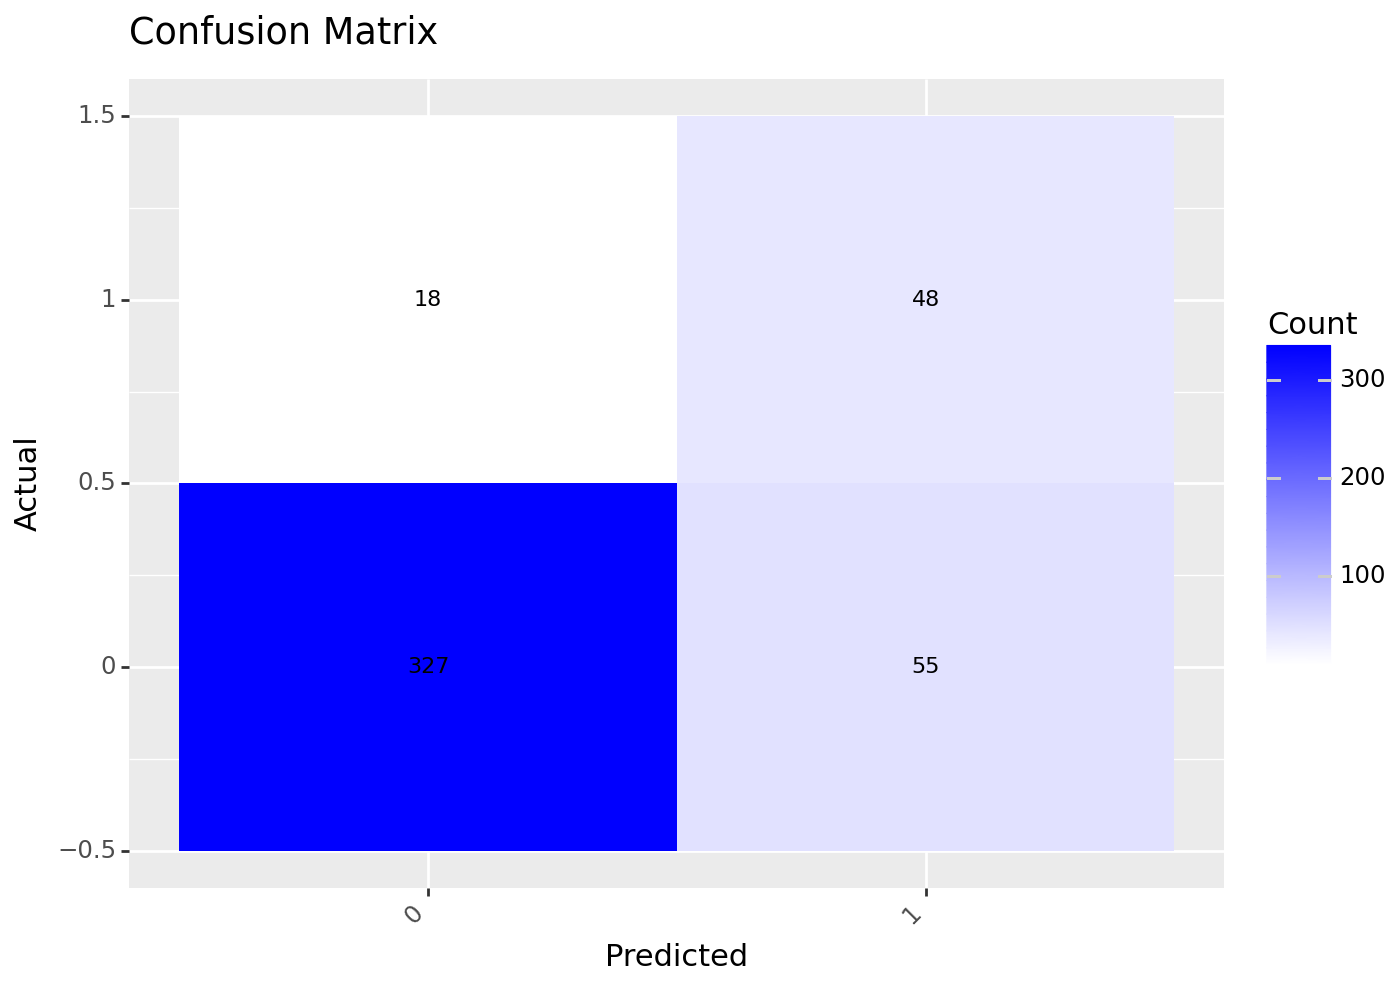

In [ ]:
def matrix_plot_ggplot(model, x_data, y_data):
    # Predict and calculate confusion matrix
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred)

    labels = model.classes_

    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    cm_df = cm_df.reset_index().melt(id_vars='index')
    cm_df.columns = ['Actual', 'Predicted', 'Count']

    plot = (
        ggplot(cm_df, aes(x='Predicted', y='Actual', fill='Count')) +
        geom_tile() +
        geom_text(aes(label='Count'), size=8) +
        scale_fill_gradient(low='white', high='blue') +
        labs(title='Confusion Matrix', x='Predicted', y='Actual') +
        theme(
            axis_text_x=element_text(angle=45, hjust=1),
            figure_size=(7, 5)
        )
    )
    print(plot)

matrix_plot_ggplot(pipe, X_test, y_test)

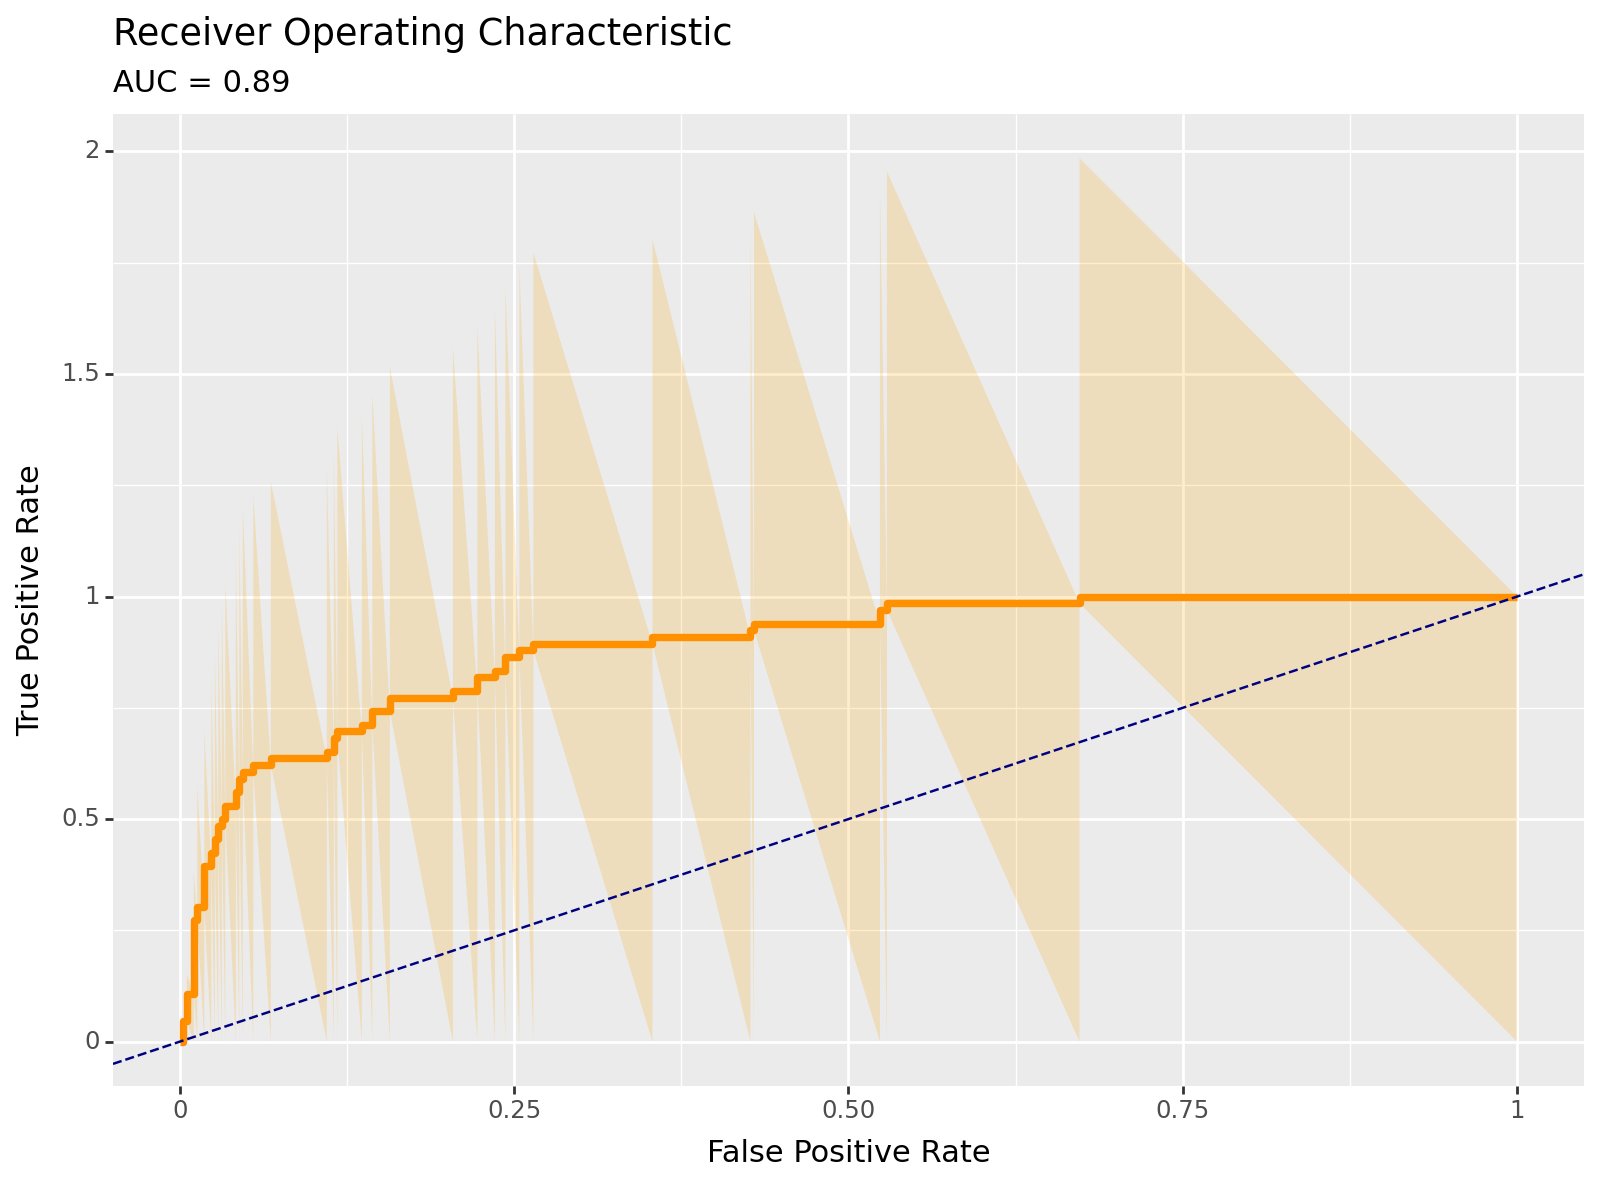

In [ ]:
# Compute ROC curve and AUC for the test set
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_prob)
roc_auc = auc(fpr, tpr)

roc_data = pd.DataFrame({'FPR': fpr, 'TPR': tpr})

roc_plot = (
    ggplot(roc_data, aes(x='FPR', y='TPR')) +
    geom_line(color='darkorange', size=1.5) +
    geom_area(alpha=0.2, fill='orange') +
    geom_abline(linetype='dashed', color='navy') +
    labs(title='Receiver Operating Characteristic',
         x='False Positive Rate', y='True Positive Rate', subtitle=f'AUC = {roc_auc:.2f}') +
    theme(figure_size=(8, 6))
)

print(roc_plot)

In [ ]:
conditions = [
    df_copy['education_2n Cycle'] == 1,
    df_copy['education_Basic'] == 1,
    df_copy['education_Graduation'] == 1,
    df_copy['education_Master'] == 1,
    df_copy['education_PhD'] == 1
]
choices = ['2n Cycle', 'Basic', 'Graduation', 'Master', 'PhD']
df_copy['Education'] = np.select(conditions, choices, default='Unknown')

continuous_vars = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntGoldProds', 'MntSweetProducts']

grouped_data = df_copy.groupby('Education')[continuous_vars].mean()

grouped_data['TotalSpending'] = grouped_data.sum(axis=1)

anova_data = df_copy[['Education'] + continuous_vars].copy()
anova_data['TotalSpending'] = anova_data[continuous_vars].sum(axis=1)

anova_model = ols('TotalSpending ~ C(Education)', data=anova_data).fit()
anova_results = sm.stats.anova_lm(anova_model, typ=2)

print(anova_results)

                    sum_sq      df          F        PR(>F)
C(Education)  1.964480e+07     4.0  13.851391  3.657678e-11
Residual      7.924499e+08  2235.0        NaN           NaN


In [ ]:
tukey_results = pairwise_tukeyhsd(endog=anova_data['TotalSpending'], groups=anova_data['Education'], alpha=0.05)
print(tukey_results)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
  group1     group2    meandiff p-adj    lower     upper   reject
-----------------------------------------------------------------
  2n Cycle      Basic -414.7308 0.0001 -663.6349 -165.8267   True
  2n Cycle Graduation  123.3718 0.0518   -0.5725   247.316  False
  2n Cycle     Master   115.254  0.174  -26.7298  257.2378  False
  2n Cycle        PhD  175.8824 0.0038   40.0342  311.7306   True
     Basic Graduation  538.1026    0.0  311.6504  764.5547   True
     Basic     Master  529.9848    0.0  293.1772  766.7924   True
     Basic        PhD  590.6132    0.0  357.4326  823.7937   True
Graduation     Master   -8.1178 0.9994 -105.5177   89.2821  False
Graduation        PhD   52.5106 0.4814  -35.7054  140.7266  False
    Master        PhD   60.6284 0.5784  -51.5291  172.7859  False
-----------------------------------------------------------------


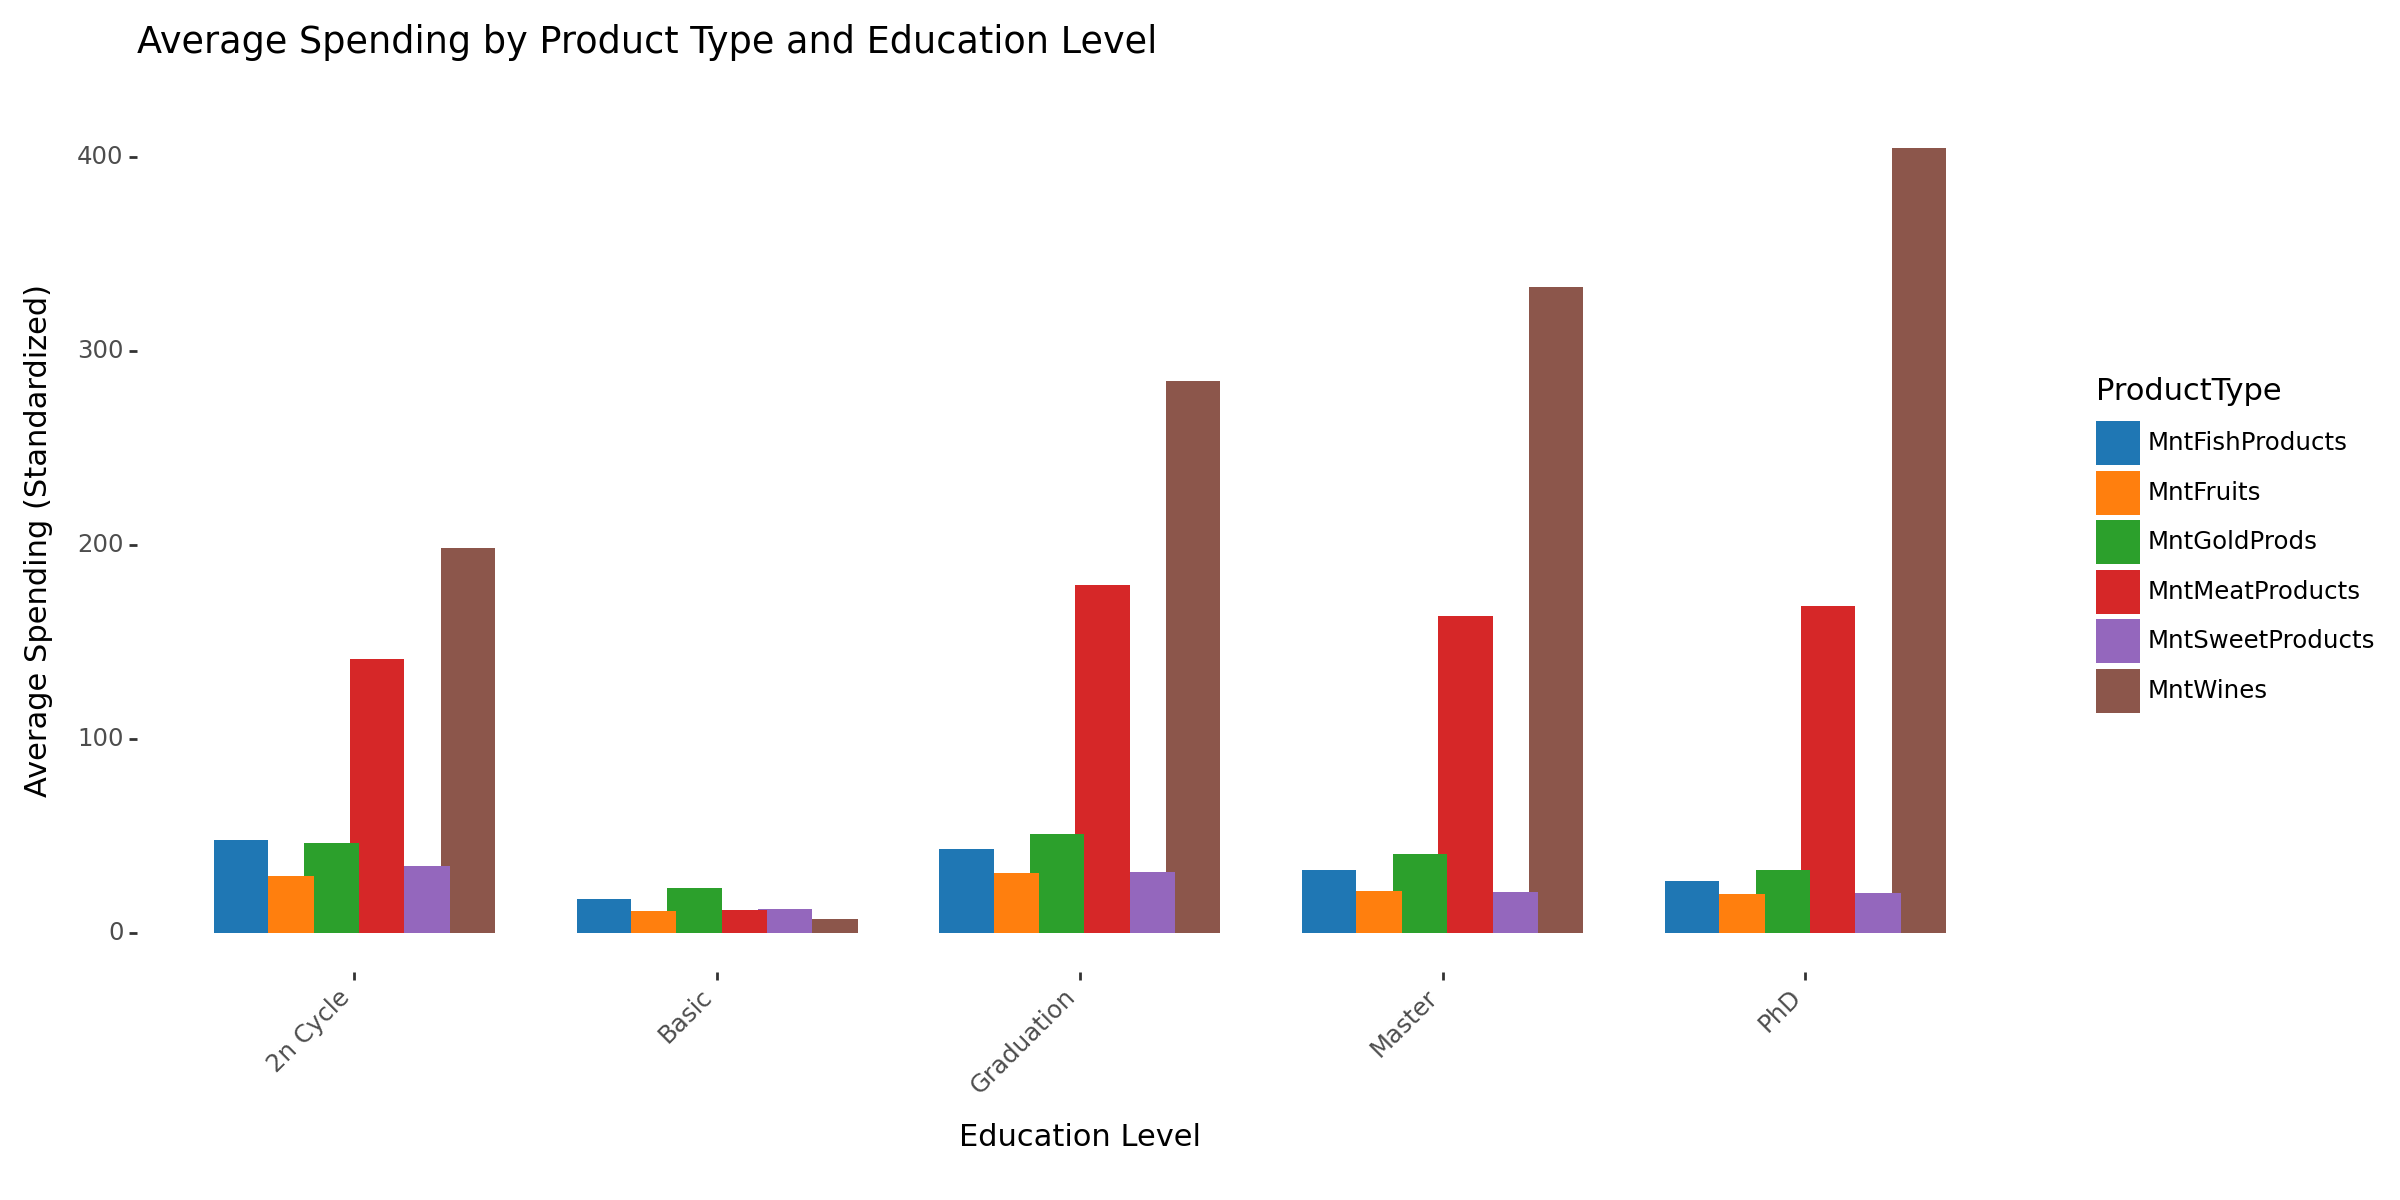

<Figure Size: (1200 x 600)>

In [ ]:
long_grouped_data = pd.melt(grouped_data.reset_index(), id_vars='Education', value_vars=['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntGoldProds', 'MntSweetProducts'], var_name='ProductType', value_name='AverageSpending')

color_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]

dodge_width = 0.75

bar_chart = (
    ggplot(long_grouped_data, aes(x='Education', y='AverageSpending', fill='ProductType')) +
    geom_bar(stat='identity', position=position_dodge(width=dodge_width)) +
    scale_fill_manual(values=color_palette) +
    labs(title='Average Spending by Product Type and Education Level', x='Education Level', y='Average Spending (Standardized)') +
    theme(
        axis_text_x=element_text(angle=45, hjust=1),
        figure_size=(12, 6),
        panel_background=element_blank(),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank()
    )
)
bar_chart

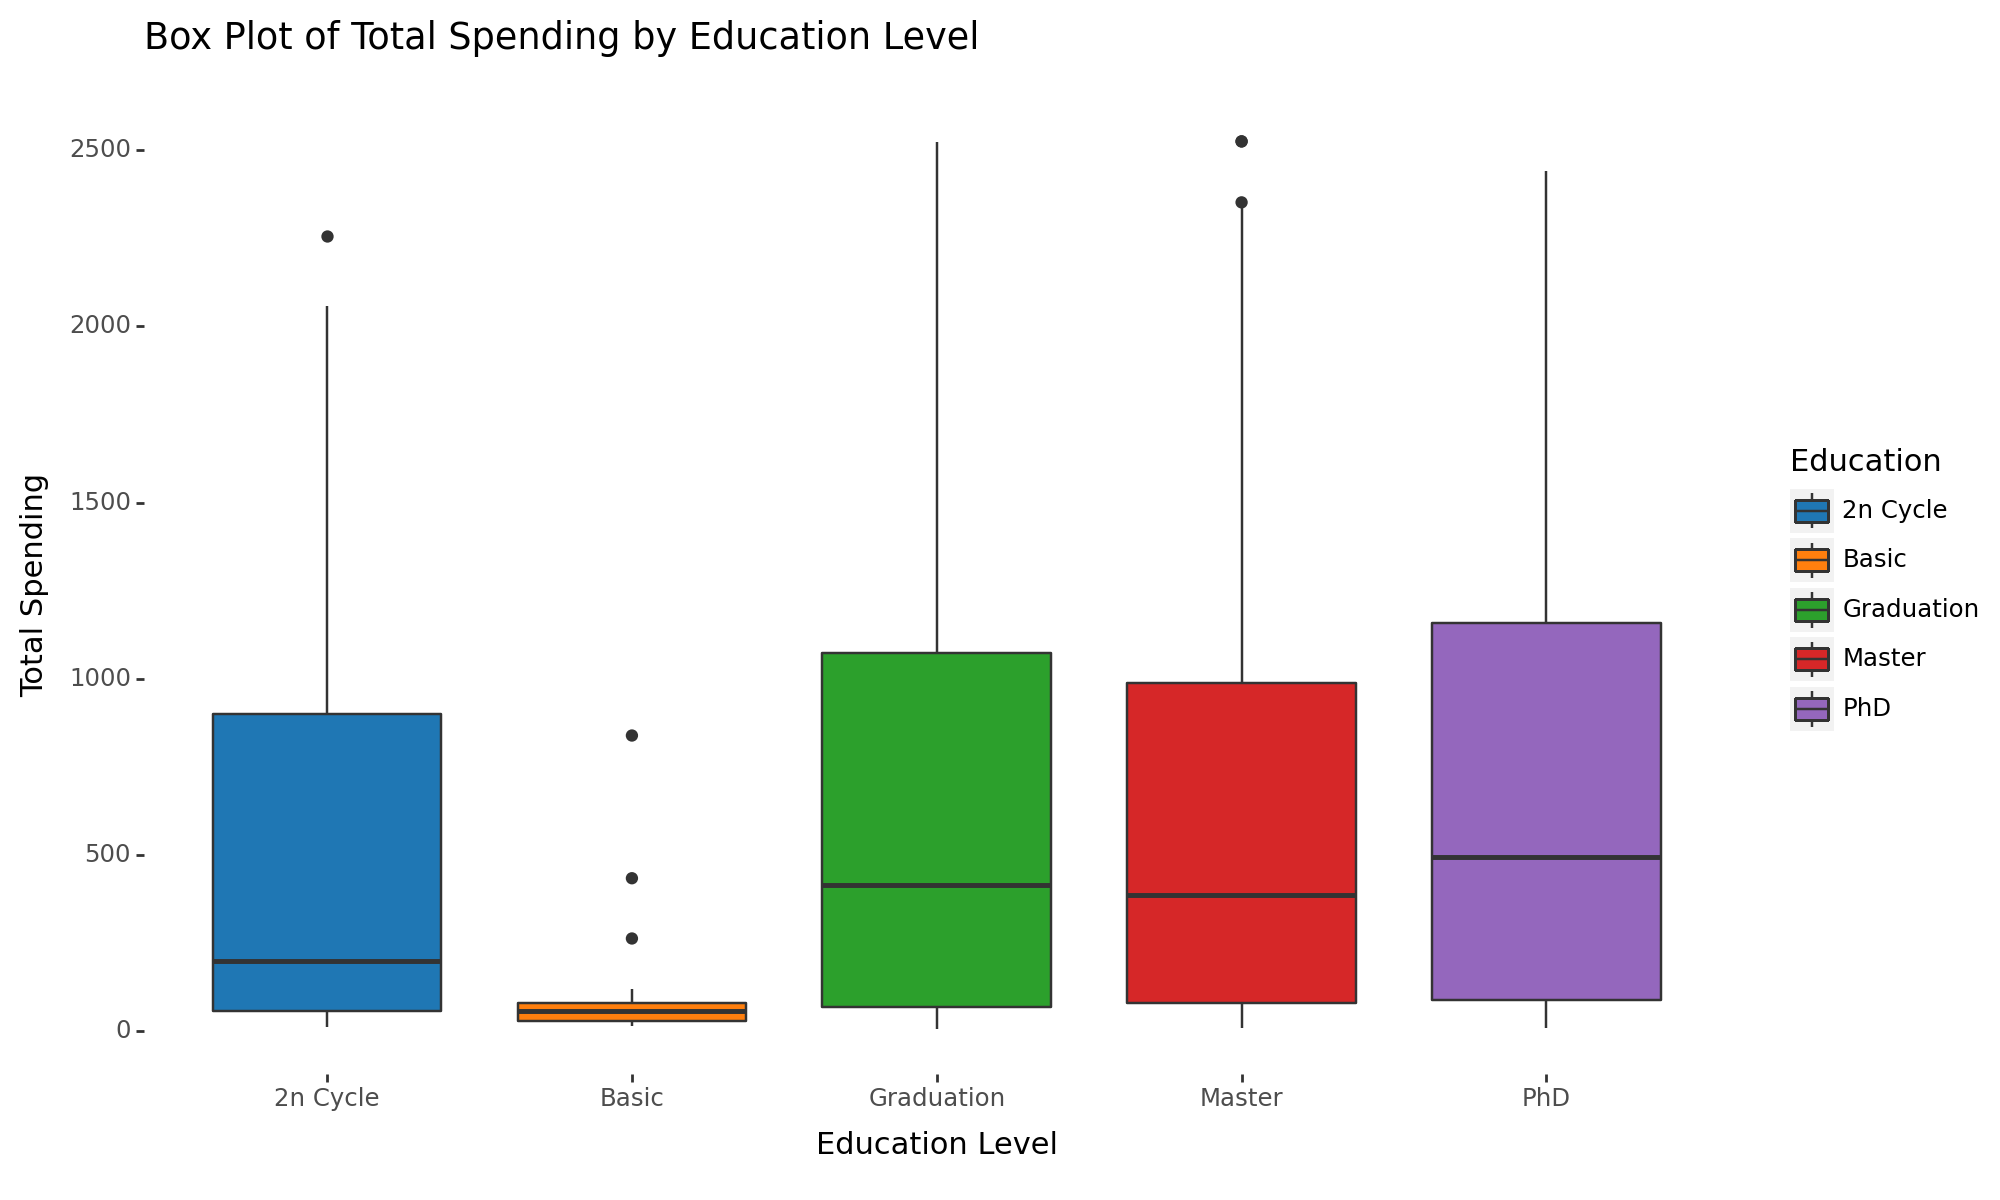

<Figure Size: (1000 x 600)>

In [ ]:
box_plot = (
    ggplot(anova_data, aes(x='Education', y='TotalSpending', fill='Education')) +
    geom_boxplot() +
    scale_fill_manual(values=color_palette) +
    labs(title='Box Plot of Total Spending by Education Level', x='Education Level', y='Total Spending') +
    theme(
        figure_size=(10, 6),
        panel_background=element_blank(),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank()
    )
)
box_plot

In [ ]:
# Reconstructing the 'Education' column from dummy variables
conditions = [
    df_copy['education_2n Cycle'] == 1,
    df_copy['education_Basic'] == 1,
    df_copy['education_Graduation'] == 1,
    df_copy['education_Master'] == 1,
    df_copy['education_PhD'] == 1
]
choices = ['2n Cycle', 'Basic', 'Graduation', 'Master', 'PhD']
df_copy['Education'] = np.select(conditions, choices, default='Unknown')

spending_vars = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

df_copy['TotalSpending'] = df_copy[spending_vars].sum(axis=1)

median_total_spending_by_education = df_copy.groupby('Education')['TotalSpending'].median()

print(median_total_spending_by_education)

Education
2n Cycle      198.0
Basic          57.0
Graduation    414.0
Master        387.5
PhD           493.0
Name: TotalSpending, dtype: float64
